In [1]:
import torch
from torch import nn, optim

from utils import *

from data_load_CMB_binary import prepare_data, CMBDataset
from vit import ViTForClassfication
from vit import *
import matplotlib.pyplot as plt
from mae import MaskedAutoEncoder
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
exp_name = 'MAE-with-20-epochs'
batch_size = 256
epochs = 50
lr = 2e-4
save_model_every = 8


config_enc = {
    "patch_size": 15,  # Input image size: 90x90 -> 6x6 patches
    "hidden_size": 400,
    "num_hidden_layers": 6,
    "num_attention_heads": 20,
    "intermediate_size": 4 * 400,
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.2,
    "image_size": 90,
    "num_channels": 1,
    "qkv_bias": True,
    "use_faster_attention": True,
}

config_dec = {
    "patch_size": 15,  # Input image size: 90x90 -> 6x6 patches
    "hidden_size": 160,
    "num_hidden_layers": 4,
    "num_attention_heads": 16,
    "intermediate_size": 4 * 160,
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.2,
    "image_size": 90,
    "num_channels": 1,
    "qkv_bias": True,
    "use_faster_attention": True,
}

# These are not hard constraints, but are used to prevent misconfigurations
assert config_enc["hidden_size"] % config_enc["num_attention_heads"] == 0
assert config_enc['intermediate_size'] == 4 * config_enc['hidden_size']
assert config_enc['image_size'] % config_enc['patch_size'] == 0

assert config_dec["hidden_size"] % config_dec["num_attention_heads"] == 0
assert config_dec['intermediate_size'] == 4 * config_dec['hidden_size']
assert config_dec['image_size'] % config_dec['patch_size'] == 0

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        # Keep track of the losses
        train_losses, test_losses, accuracies = [], [], []
        
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_MAE_experiment(self.exp_name, config_enc, config_dec, self.model, 
                            train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            
            # Zero the gradients
            self.optimizer.zero_grad()
            
            # Calculate the loss
            loss, _, _ = self.model.forward(1/200*images, 0.2)
            
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get the loss
                loss, _, _ = self.model.forward(1/200*images, 0.2)

                total_loss += loss.item() * len(images)
                
        avg_loss = total_loss / len(testloader.dataset)
        return avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the  dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size, 
                                              train_sample_size=50000, test_sample_size=3000)
    
    # Create the model, optimizer, loss function and trainer
    trained_class = "./experiments/MAE-with-20-epochs/model_final.pt"
    model = MaskedAutoEncoder(config_enc, config_dec)
    model.load_state_dict(torch.load(trained_class, map_location=torch.device('cpu')))
    model.eval()
    model = model.to('cuda')
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-2)
    trainer = Trainer(model, optimizer, exp_name, device='cuda')
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()

In [5]:
config_enc, config_dec, model, train_losses, test_losses = load_MAE_experiment(f"{exp_name}/",
                                                                               checkpoint_name="model_final.pt")

In [7]:
rand_test_size = 10

rand_test_set = CMBDataset(CMB_loc = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/param_CNN/Data_hp/',
                               etadir_loc = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/param_CNN/Data/',
                               number_of_sampls = rand_test_size, device = "cpu")

images = torch.tensor([np.asarray(1/200*rand_test_set[i][0]) for i in range(10)])
images = images.to(device)
model = model.to(device)

loss, pred, mask = model.forward(images)

/tmp/ipykernel_60/1308928925.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  images = torch.tensor([np.asarray(1/200*rand_test_set[i][0]) for i in range(10)])


In [8]:
event_num = 1
true_im =images[event_num][0].to('cpu')
true_mask =mask[event_num].to('cpu')

img = model.unpatchify(pred.detach().to('cpu'))
predimg = img[event_num][0]

In [9]:
true_mask_mat = true_mask.reshape((6,6))
pads = torch.tensor(np.ones((15,15)))
pix_nomask_pad= 1-torch.kron(true_mask_mat,pads)
pix_mask_pad = torch.kron(true_mask_mat,pads)

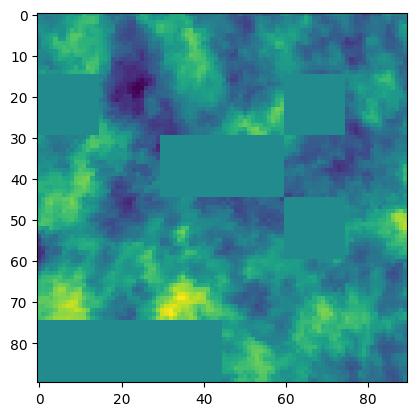

In [10]:
plt.imshow(pix_nomask_pad*true_im)

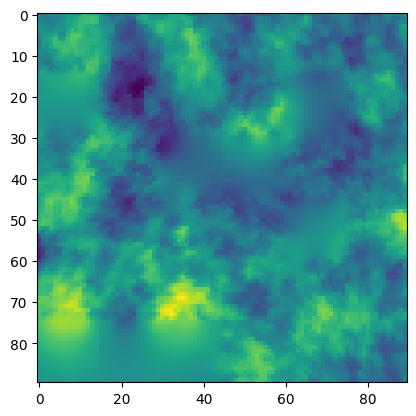

In [11]:
plt.imshow(pix_nomask_pad*true_im+predimg*pix_mask_pad)

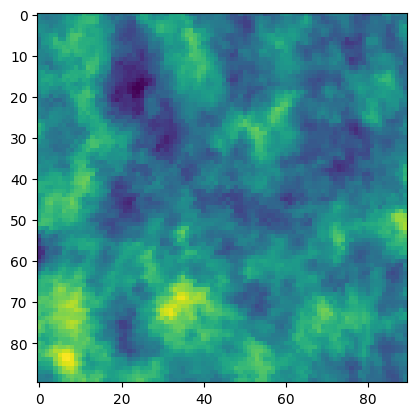

In [12]:
plt.imshow(true_im)